Aprendizaje profundo / MLP con Early Stopping y Dropout (Core)

MLP con Early Stopping y Dropout (Core)
Descripción:

En esta actividad, implementarás una red MLP más avanzada, utilizando técnicas como dropout y early stopping para evitar el sobreajuste. El dataset seleccionado es el «Heart Disease UCI» de Kaggle, donde se intentará predecir si un paciente tiene una enfermedad cardíaca o no basándose en varias características.

# 1. Carga de datos:
* Descarga el dataset «Heart Disease UCI» de Kaggle. Explora las características que están relacionadas con la edad, el sexo, la presión arterial y otras variables clínicas.
* Verifica si hay valores nulos en el dataset y realiza el preprocesamiento necesario, como la imputación de valores faltantes y la normalización de las variables numéricas.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('./data/HeartDiseaseTrain-Test.csv')

In [ ]:
print("Valores faltantes:", data.isnull().sum())
data.head()

Valores faltantes: age                              0
sex                              0
chest_pain_type                  0
resting_blood_pressure           0
cholestoral                      0
fasting_blood_sugar              0
rest_ecg                         0
Max_heart_rate                   0
exercise_induced_angina          0
oldpeak                          0
slope                            0
vessels_colored_by_flourosopy    0
thalassemia                      0
target                           0
dtype: int64


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1025 non-null   int64  
 1   sex                            1025 non-null   object 
 2   chest_pain_type                1025 non-null   object 
 3   resting_blood_pressure         1025 non-null   int64  
 4   cholestoral                    1025 non-null   int64  
 5   fasting_blood_sugar            1025 non-null   object 
 6   rest_ecg                       1025 non-null   object 
 7   Max_heart_rate                 1025 non-null   int64  
 8   exercise_induced_angina        1025 non-null   object 
 9   oldpeak                        1025 non-null   float64
 10  slope                          1025 non-null   object 
 11  vessels_colored_by_flourosopy  1025 non-null   object 
 12  thalassemia                    1025 non-null   o

In [ ]:
def convert_object_to_category(data):
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = data[col].astype('category')
    return data

# Usando la función en tu dataset
data = convert_object_to_category(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            1025 non-null   int64   
 1   sex                            1025 non-null   category
 2   chest_pain_type                1025 non-null   category
 3   resting_blood_pressure         1025 non-null   int64   
 4   cholestoral                    1025 non-null   int64   
 5   fasting_blood_sugar            1025 non-null   category
 6   rest_ecg                       1025 non-null   category
 7   Max_heart_rate                 1025 non-null   int64   
 8   exercise_induced_angina        1025 non-null   category
 9   oldpeak                        1025 non-null   float64 
 10  slope                          1025 non-null   category
 11  vessels_colored_by_flourosopy  1025 non-null   category
 12  thalassemia                    102

# 2. Exploración y preprocesamiento de datos:
* Realiza una división del dataset en conjunto de entrenamiento y prueba. Asegúrate de que el dataset esté bien balanceado, verificando la distribución de la variable objetivo (enfermedad cardíaca sí/no).


In [ ]:
# Definir las columnas categóricas y numéricas
columnas_categoricas = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg',
                        'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']
columnas_numericas = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']

# Separar las características y el target
X = data.drop(columns=['target'])
y = data['target']

# Inicializar el scaler para normalizar las columnas numéricas
scaler = MinMaxScaler()

# Inicializar el LabelEncoder para las columnas categóricas
label_encoder = LabelEncoder()

# Normalización de las columnas numéricas
X[columnas_numericas] = scaler.fit_transform(X[columnas_numericas])

# Codificación de las columnas categóricas usando LabelEncoder
for col in columnas_categoricas:
    X[col] = label_encoder.fit_transform(X[col])

# División del dataset en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Implementación y entrenamiento de la MLP con Dropout:
* Implementa una red MLP con dos capas ocultas utilizando Keras o cualquier biblioteca de deep learning.
* Agrega capas de dropout después de cada capa oculta para reducir el riesgo de sobreajuste. Utiliza una tasa de dropout del 20-30%.
* Implementa el early stopping para detener el entrenamiento cuando la precisión en el conjunto de validación deje de mejorar después de varias épocas (por ejemplo, paciencia de 5 épocas).

In [ ]:
# Crear el modelo MLP con dos capas ocultas y Dropout
model = Sequential()

# Capa de entrada y primera capa oculta con Dropout
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa oculta 1
model.add(Dropout(0.25))  # Tasa de dropout del 25%

# Segunda capa oculta con Dropout
model.add(Dense(32, activation='relu'))  # Capa oculta 2
model.add(Dropout(0.25))  # Tasa de dropout del 25%

# Capa de salida
model.add(Dense(1, activation='sigmoid'))  # Salida binaria (0 o 1)

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping para detener el entrenamiento si no hay mejora en la precisión de validación después de 5 épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5347 - loss: 0.7738 - val_accuracy: 0.7073 - val_loss: 0.5921
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7207 - loss: 0.5710 - val_accuracy: 0.8098 - val_loss: 0.4731
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7868 - loss: 0.5013 - val_accuracy: 0.8195 - val_loss: 0.4299
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7658 - loss: 0.4991 - val_accuracy: 0.8244 - val_loss: 0.4132
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7963 - loss: 0.4505 - val_accuracy: 0.8244 - val_loss: 0.4011
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8248 - loss: 0.4085 - val_accuracy: 0.8244 - val_loss: 0.3903
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7987 - loss: 0.4274 - val_accuracy: 0.8488 - val_loss: 0.3833
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8339 - loss: 0.4113 - val_accuracy: 0.8341 - val_loss

## – Visualiza las curvas de aprendizaje

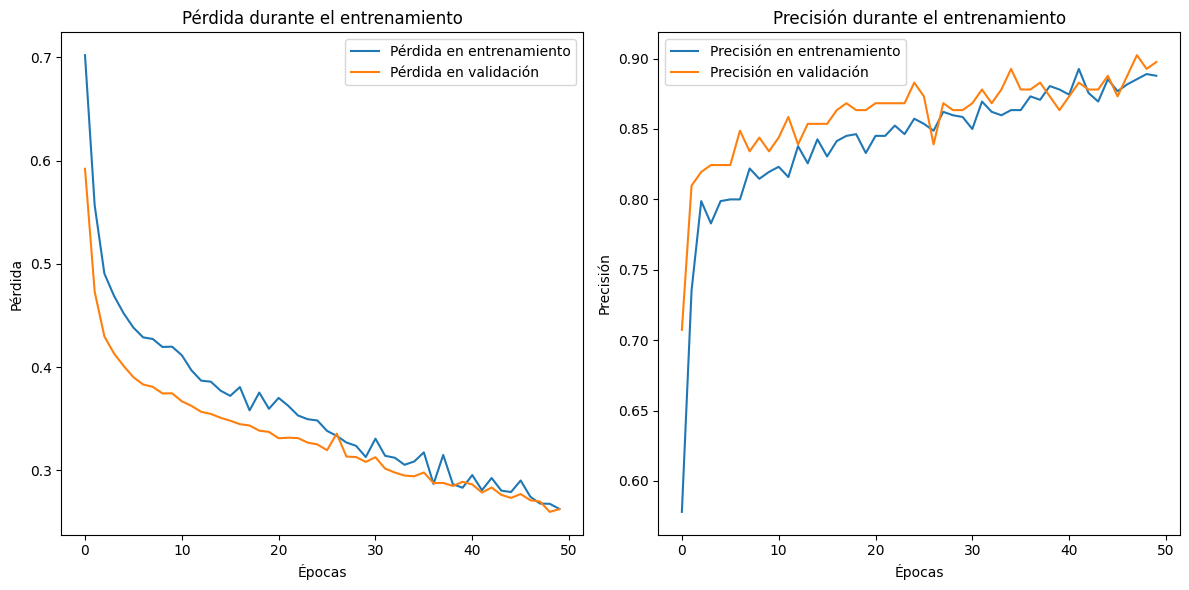

In [ ]:
# Visualización de las curvas de aprendizaje
def plot_learning_curves(history):
    # Pérdida
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida en validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión en validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

# 5. Evaluación del modelo:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.89      0.89      0.89       100
     Clase 1       0.90      0.90      0.90       105

    accuracy                           0.89       205
   macro avg       0.89      0.89      0.89       205
weighted avg       0.89      0.89      0.89       205



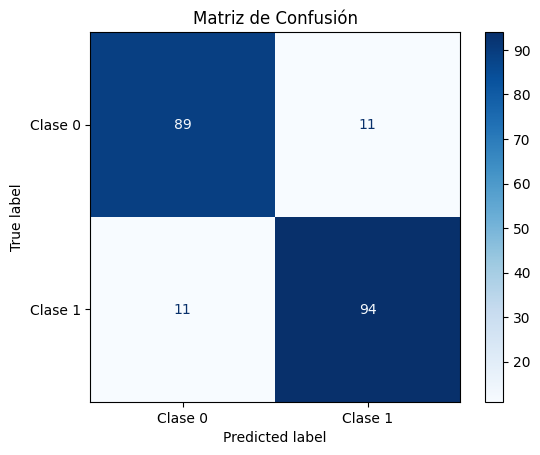

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convertir probabilidades a etiquetas binarias (0 o 1)

# Generar reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Clase 0', 'Clase 1']))

# Generar matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Clase 0', 'Clase 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

El dropout y el early stopping son tecnicas que disminuyen el riesgo a sobreajuste ademas de que agilizan el proceso al reducir el tiempo de entrenamiento, esto repercute en un menor costo computacional con respecto a los modelos que no utlizan estas tecnicas